In [2]:
from tabascal.jax.interferometry import rfi_vis
from tabascal.jax.coordinates import orbit

import matplotlib.pyplot as plt
import numpy as np

import xarray as xr

In [114]:
plt.rcParams['font.size'] = 18

In [4]:
rfi_cov = np.load("data/RFIorbitCov5min.npy")

In [173]:
N_ant = 16

xds = xr.open_zarr(f'/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/target_obs_{N_ant:02}A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_1SAT_0GRD/')

In [174]:
N_s = 100
sampling = 64

t = xds.time_fine.data[sampling//2::sampling]
freqs = xds.freq.data
a1 = xds.antenna1.data.compute()
a2 = xds.antenna2.data.compute()

rfi_mu = xds.rfi_sat_orbit.compute()[0].data
rfi_orbit = np.random.multivariate_normal(rfi_mu, rfi_cov, size=(N_s,))

ants_xyz = xds.ants_xyz.data[sampling//2::sampling].compute()
ants_uvw = xds.ants_uvw.data[sampling//2::sampling].compute()

rfi_xyz = np.array([orbit(t, *params) for params in rfi_orbit])
distances = np.linalg.norm(ants_xyz[None, :, :, :] - rfi_xyz[:, :, None, :], axis=-1)

N_t = len(t)
N_f = len(freqs)
N_a = ants_xyz.shape[1]

In [175]:
vis_rfi = np.array([rfi_vis(np.ones((1,N_t,N_a,N_f)), d - ants_uvw[None, :, :, -1], freqs, a1, a2) for d in distances])[:,:,:,0]

In [176]:
distances = np.linalg.norm(ants_xyz[None, :, :, :] - orbit(t, *rfi_mu)[None, :, None, :], axis=-1)
vis_rfi_true = rfi_vis(np.ones((1,N_t,N_a,N_f)), distances - ants_uvw[None, :, :, -1], freqs, a1, a2)[:,:,0]

In [177]:
vis_rfi.shape, vis_rfi_true.shape

((100, 900, 120), (900, 120))

In [178]:
vis_phase = np.rad2deg(np.unwrap(2*np.arctan(vis_rfi.imag/vis_rfi.real), axis=1, discont=0.0)/2)
vis_phase_true = np.rad2deg(np.unwrap(2*np.arctan(vis_rfi_true.imag/vis_rfi_true.real), axis=0, discont=0.0)/2)

In [179]:
vis_phase_mean = np.mean(vis_phase, axis=0)
vis_phase_std = np.std(vis_phase, axis=0)

Text(0, 0.5, 'Phase Deviation [deg]')

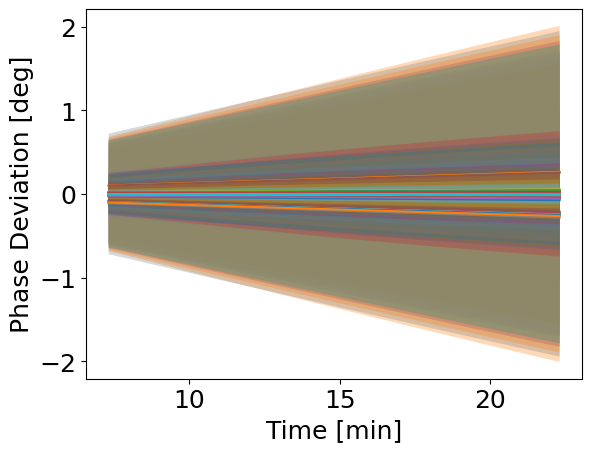

In [180]:
for i in range(vis_phase.shape[-1]):
    plt.plot(t/60, vis_phase_mean[:,i]-vis_phase_true[:,i])
    plt.fill_between(t/60, -vis_phase_std[:,i], vis_phase_std[:,i], alpha=0.3)
    
plt.xlabel('Time [min]')
plt.ylabel('Phase Deviation [deg]')

Text(0, 0.5, 'Phase Deviation Std [deg]')

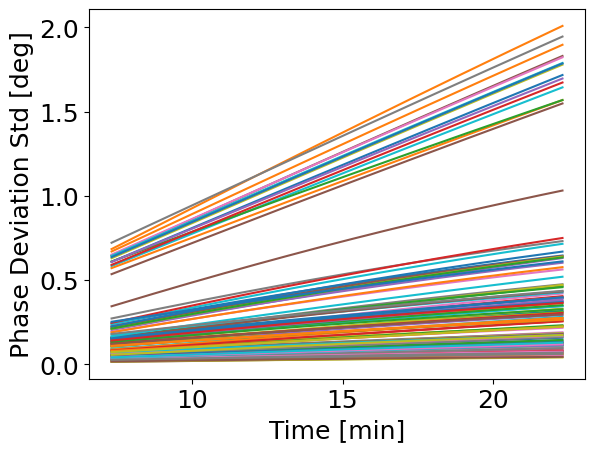

In [182]:
plt.plot(t/60, vis_phase_std)

plt.xlabel('Time [min]')
plt.ylabel('Phase Deviation Std [deg]')

Text(0, 0.5, 'Phase Deviation Rate [deg/min]')

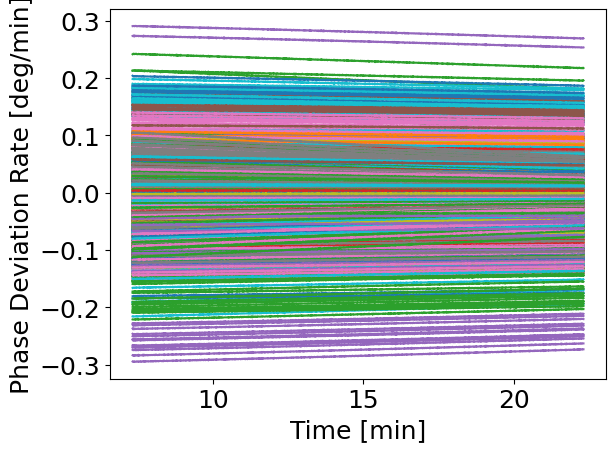

In [189]:
for i in range(vis_phase.shape[2]):
    plt.plot(t[1:]/60, 60*np.diff(vis_phase[:,:,i].T-vis_phase_true[None,:,i].T, axis=0))

plt.xlabel('Time [min]')
plt.ylabel('Phase Deviation Rate [deg/min]')